# 118B Final Project: Target Risk-Genes of ASD
Yufei Deng, Mengyu Zhang

## Dataset:
- Source: Gene Expression Omnibus (GEO) 

    - Alter MD, Kharkar R, Ramsey KE, Craig DW et al. Autism and increased paternal age related changes in global levels of gene expression regulation. PLoS One 2011 Feb 17;6(2):e16715. PMID: 21379579
- Link to data: https://ftp.ncbi.nlm.nih.gov/geo/series/GSE25nnn/GSE25507/matrix/


## Objectives
Using Feature Selection techniques and classification algorithms to pinpoint a set of risk genes of ASD in children

## Data Analysis

In [4]:
!pip install umap-learn

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

import seaborn as sns
import umap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [6]:
gene = pd.read_csv('Data/ASD gene expression.csv', header=None).transpose()

/Users/yufeideng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
# reset var headers
gene.columns = gene.iloc[0,:]
gene = gene.iloc[1:,:-1]

# clean first 4 columns
for i in ['group','age','paternal age','maternal age']:
    gene[i] = gene[i].apply(lambda x: x[x.index(':')+2 : ])
# define NA & convert data type
gene = gene.replace('n/a',np.NaN)
gene.iloc[:, 1:] = gene.iloc[:, 1:].astype('float')

# log2 transformation
gene.iloc[:,4:] = np.log2(gene.iloc[:,3:])

# fill NAs with sample mean
gene = gene.fillna(gene.groupby(by='group').transform('mean'))

In [8]:
gene.head()

,group,age,paternal age,maternal age,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,...,90610_at,91580_at,91617_at,91682_at,91684_g_at,91703_at,91816_f_at,91826_at,91920_at,91952_at
1,control,8.0,25.0,27.000000,7.490435,6.888543,10.211710,7.065359,2.852363,9.954682,...,10.97507,2.527711,7.398393,5.481846,6.890669,9.435545,4.259138,5.440124,6.488415,8.182494
2,control,5.0,32.0,29.680851,7.321750,7.080919,9.691980,7.336830,3.229999,9.616889,...,11.02510,2.665741,7.420699,5.519685,6.811520,9.323536,4.229679,5.239554,6.428158,7.591741
3,control,8.0,29.0,27.000000,7.321028,7.056038,9.804575,7.131661,2.895505,9.784978,...,10.75234,2.650831,7.136440,5.567495,7.061603,9.237819,4.108562,5.324160,6.513687,7.939579
4,control,7.0,35.0,28.000000,6.824749,7.064454,10.745700,7.506029,3.035141,9.650617,...,11.07170,2.856018,7.001532,5.746933,7.126472,10.350680,3.482814,5.663636,6.810707,8.327817
5,control,4.0,36.0,29.680851,7.187857,6.597835,9.641562,7.439269,2.928376,10.075270,...,11.03501,2.750070,7.660148,5.578431,6.850351,9.494425,4.080456,5.781827,6.766291,7.408037


## Visualizing Raw Data with UMAP

In [79]:
def draw_umap(data):
    embedding = umap.UMAP().fit_transform(data)
   
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1],
                hue=gene.group, 
                hue_order=['autism','control'],
                palette='hls')

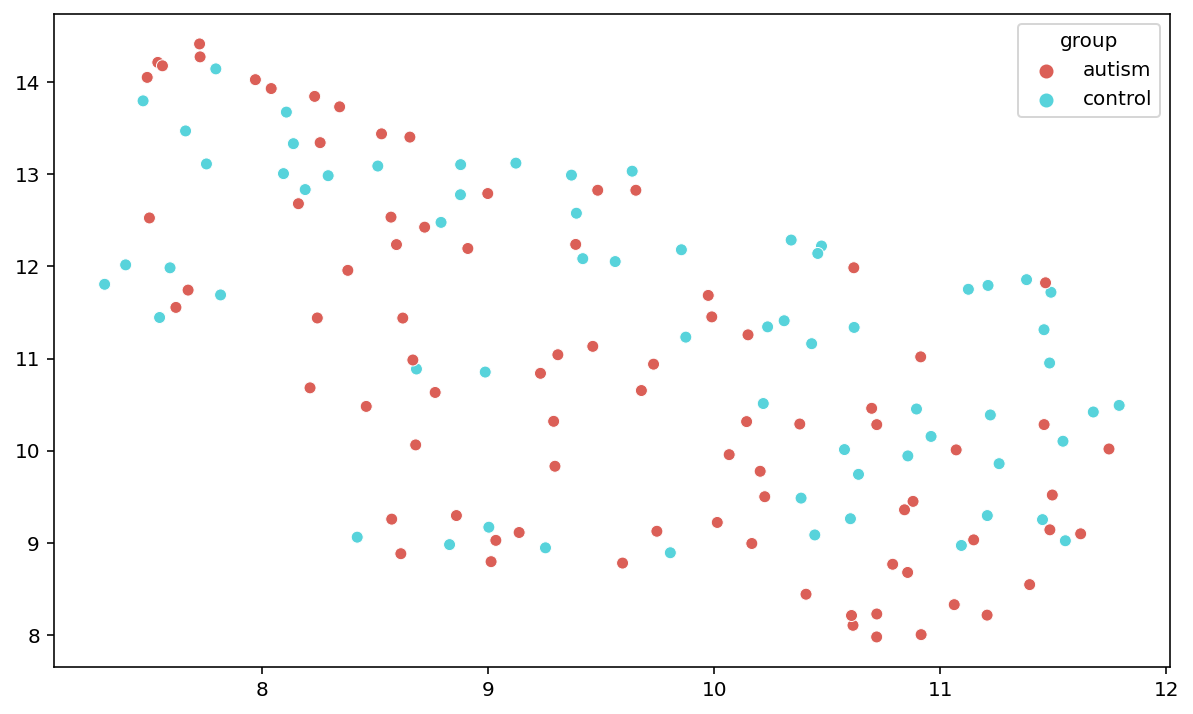

In [80]:
raw_data = gene.iloc[:,1:].values
draw_umap(raw_data)

## Filter with Variance

In [81]:
variance_df = pd.DataFrame(gene.iloc[:,4:].apply(np.var,axis=0),
                          columns=['variance'])
ind = variance_df[variance_df['variance'] >0.287].index
ind = list(gene.columns[1:4]) +list(ind)

In [82]:
gene_flt = gene.loc[:, ind]

In [85]:
flt1_data = gene_flt.iloc[:,1:]

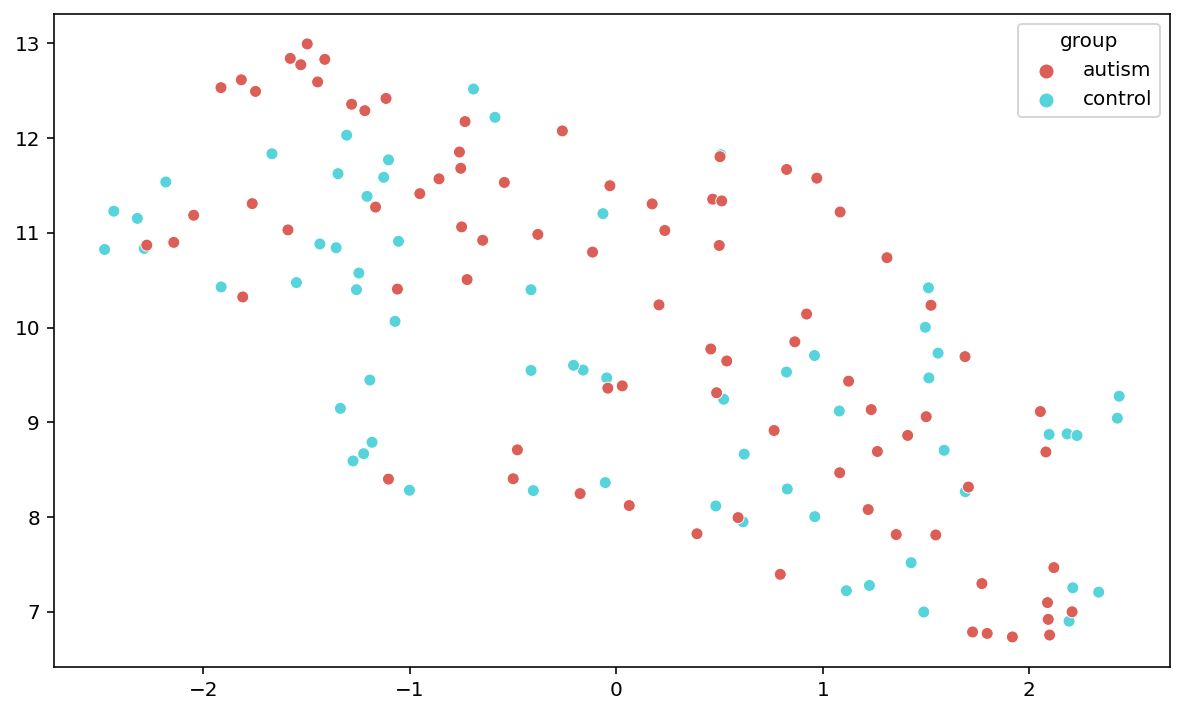

In [86]:
draw_umap(flt1_data)

## Filter by Feature importance with Random Trees

In [87]:
X = gene_flt
y = gene['group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [88]:
feature_names = [f"{i}" for i in X.columns]
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [89]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

In [90]:
feature_imp = pd.DataFrame({'feature':feature_names,'imp':importances})
feature_imp = feature_imp.sort_values(by='imp', ascending=False)

flted_features = list(feature_imp[feature_imp['imp']!=0]['feature'])
feature_imp.head()

,feature,imp
0,age,0.015871
2171,226085_at,0.008203
1727,218638_s_at,0.006666
562,202890_at,0.006142
1491,214805_at,0.005722


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

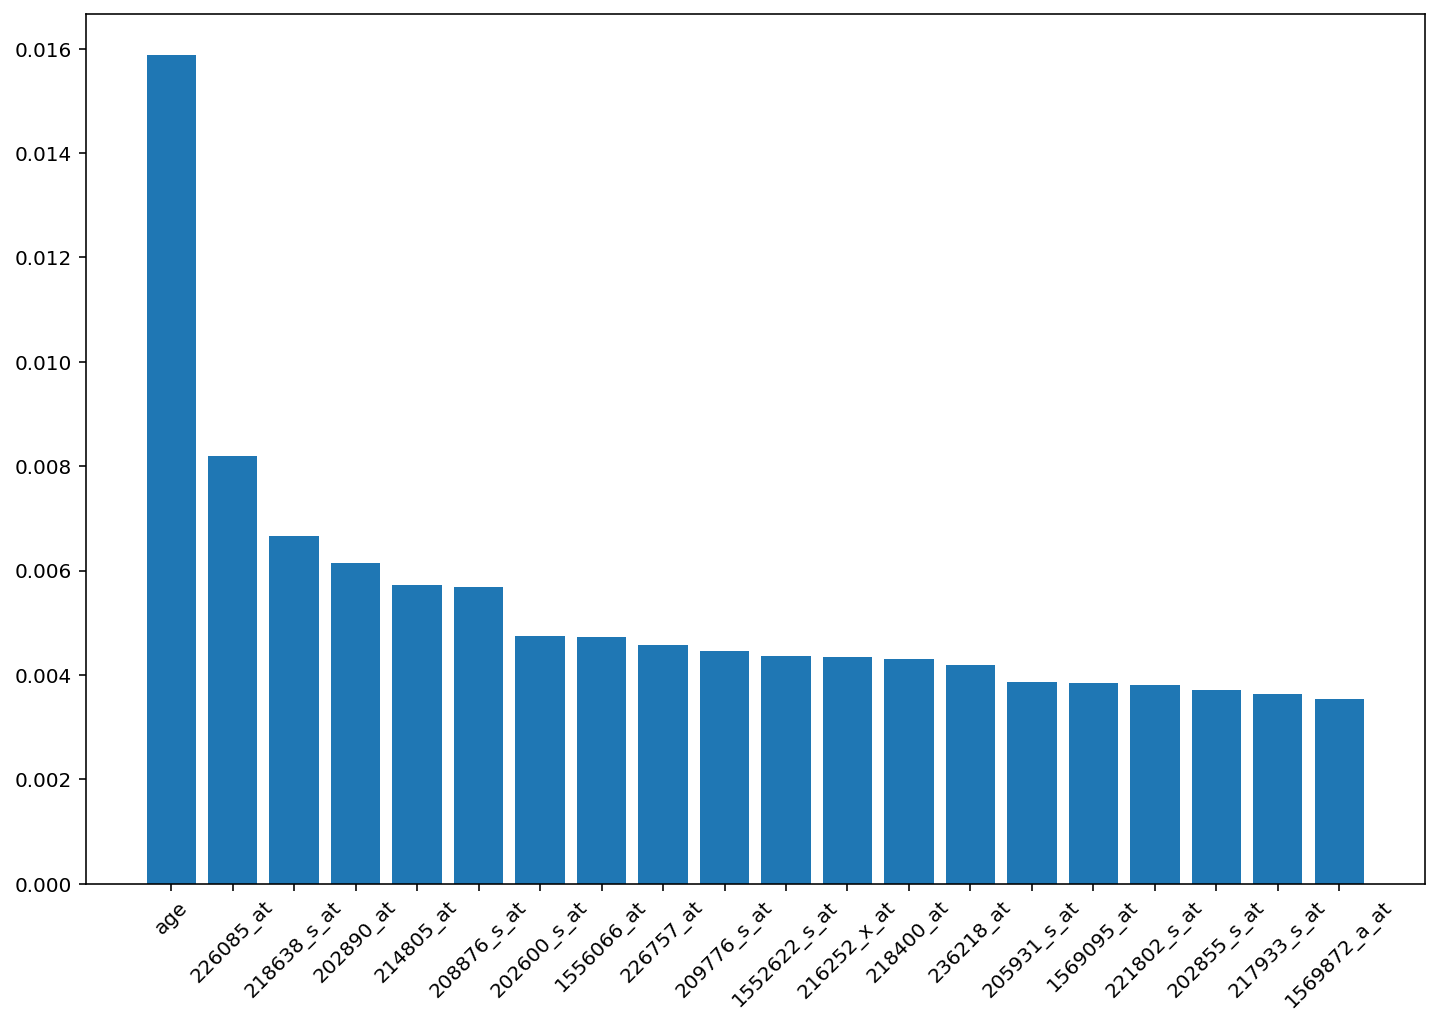

In [91]:
plt.figure(figsize=(12,8))
plt.bar('feature','imp', data=feature_imp[:20])
plt.xticks(rotation=45)

In [92]:
#final filtered dataset
data = gene_flt.loc[:, flted_features]
data.head()

,age,226085_at,218638_s_at,202890_at,214805_at,208876_s_at,202600_s_at,1556066_at,226757_at,209776_s_at,...,211021_s_at,1557300_s_at,204140_at,202444_s_at,217851_s_at,201399_s_at,201120_s_at,212887_at,244267_at,228248_at
1,8.0,5.124983,9.206396,5.130130,7.284826,6.665062,6.963088,7.390322,9.876129,6.319928,...,7.217013,5.097667,6.107741,5.924585,5.862169,10.022960,8.695408,7.577276,4.735145,8.810917
2,5.0,5.598485,9.623928,5.734943,6.632059,6.139602,6.874063,7.006169,10.442880,6.426961,...,7.136839,5.146588,7.087797,6.031079,5.975215,9.754224,7.979452,7.948852,3.940398,9.158487
3,8.0,4.797966,9.786287,6.054407,7.170240,6.677867,5.836493,6.434269,10.537750,6.524821,...,7.485169,5.358429,7.111063,5.641002,6.082054,9.905098,8.776729,8.144234,4.167684,8.825907
4,7.0,3.919054,9.604731,5.187885,5.898286,6.621995,3.935011,7.512616,10.423510,6.965080,...,7.767156,4.227385,6.092095,5.140254,4.432997,9.196247,7.895643,7.148548,3.426030,8.750092
5,4.0,4.910948,10.070960,4.083191,6.326445,5.548347,6.294639,6.862373,12.806520,4.841103,...,4.881159,4.593283,6.367415,4.015145,6.145096,8.062809,6.822915,8.126244,3.784342,9.019450


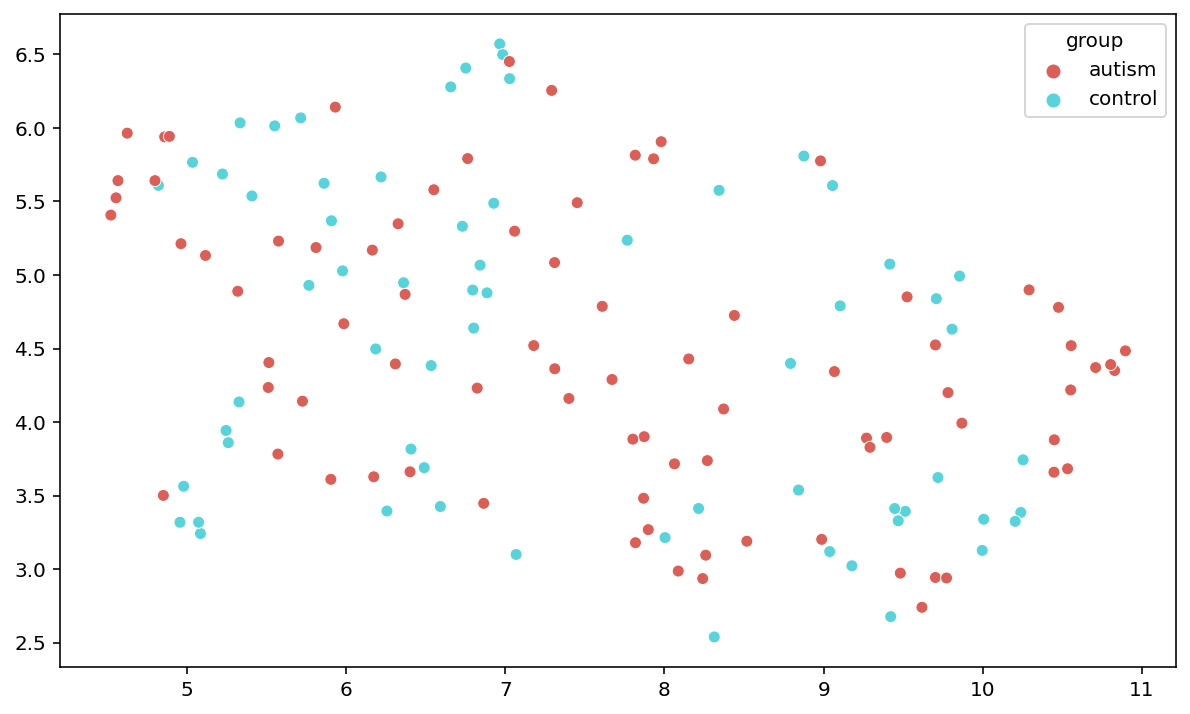

In [95]:
draw_umap(data.values)

## Classification

In [146]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [158]:
score_train, score_test = [],[]

def my_SVM_CV(n_splits=5): # for k-fold cross-validation):
    X = data.values
    y = gene['group'].values
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold=0
    clf_report_train = clf_report_test = []

    
    for train, test in kf.split(X):
        # obtain classifier
        clf = SVC(random_state=42).fit( X[train,:], y[train] )
        # train report
        train_pred = clf.predict(X[train,:])
#         clf_report_train.append(classification_report(train_pred, y[train]))
        # test report
        test_pred = clf.predict(X[test,:])
#         clf_report_test.append(classification_report(test_pred, y[test]))
        score_train.append( accuracy_score(train_pred, y[train]) )
        score_test.append( accuracy_score(test_pred, y[test]) )
    
        fold+=1
        
    return score_train, score_test


In [159]:
n_splits = 5
# clf_report_train, clf_report_test = my_SVM_CV(n_splits)
score_train, score_test = my_SVM_CV(n_splits)

In [160]:
score_train, score_test

([0.6724137931034483,
  0.6153846153846154,
  0.7606837606837606,
  0.6752136752136753,
  0.7264957264957265],
 [0.5,
  0.4827586206896552,
  0.6206896551724138,
  0.5862068965517241,
  0.6206896551724138])

In [ ]:

mse_train,mse_test = np.zeros([n_splits,len(k_values)]), np.zeros([n_splits,len(k_values)])
ik = 0
for k in k_values:
    mse_train[:,ik],mse_test[:,ik] = my_regression_CV(k,n_splits)
    ik+=1